# **Week 5: Feature Selection and Regularization on the Ames Housing Dataset**

In this homework, we will experiment with two feature selection methods and one regularization technique for linear regression:
- **Forward Selection**
- **Backward Selection**
- **Ridge Regression**

We will apply these techniques to the preprocessed Ames Housing dataset from last week, evaluate which method achieves the best cross-validation (CV) score, and provide a final test score for the best model. 

There are 4 problems with 8 graded answers worth 6 points each, and you get 2 points free. 

In [102]:
# Useful imports

import os
import kagglehub
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import requests
import io
import zipfile

from sklearn.model_selection   import train_test_split, cross_val_score
from sklearn.linear_model      import LinearRegression,Ridge,Lasso
from sklearn.model_selection   import GridSearchCV
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.metrics           import mean_squared_error, r2_score
from sklearn.preprocessing     import StandardScaler 


## **Prelude: Download the Preprocessed Ames Housing Dataset**

I have stored the dataset as a zipped directory containing the following four files from an 80%-20% split of the Ames dataset after preprocessing (as done in the last homework):

- `X_train.csv`         
- `y_train.csv`
- `X_test.csv`          
- `y_test.csv`

**TODO:** Run the following cell to download and extract the dataset into the current working directory of this notebook.  
Alternatively, you can manually download the zip file from the provided URL, extract it, and place the files in the same directory as your notebook.

> ⚠️ **Important:**  
> DO NOT use your own version of these datasets from the last homework. The autograder expects the exact split provided in my files for both training and testing sets. Using any other split will result in incorrect results during grading.


In [103]:
# Download the Ames Housing Dataset from Snyder's web site

# URL to the zip file
zip_url = "https://www.cs.bu.edu/fac/snyder/cs505/Data/ames_housing.zip"

try:
    response = requests.get(zip_url)
    response.raise_for_status()  # Raise an error for bad status codes
    with zipfile.ZipFile(io.BytesIO(response.content)) as zipf:
        zipf.extractall("ames_data")
    print("Files downloaded and extracted successfully.")
except requests.exceptions.RequestException as e:
    print(f"Error downloading the file: {e}")

# Load the datasets
X_train = pd.read_csv("ames_data/X_train.csv")
X_test = pd.read_csv("ames_data/X_test.csv")
y_train = pd.read_csv("ames_data/y_train.csv").squeeze("columns")          # converted to a Series
y_test = pd.read_csv("ames_data/y_test.csv").squeeze("columns")

print("Training and testing datasets loaded successfully.")


Files downloaded and extracted successfully.
Training and testing datasets loaded successfully.


## **Problem One: Forward Selection with the Ames Dataset**

For our first experiment we will apply the forward feature selection algorithm to the dataset. Follow these steps, using the notebook from this week's video lesson as a resource as necessary. 

**If you have not looked at the video yet, please do it now before continuing.**

**Steps to Follow:**
1. **Observe** that we have provided the `forward_feature_selection` algorithm from the video notebook for you to use.

2. **Copy** from the video notebook into the cell indicated below the code that runs forward feature selection and generates a plot (excluding the part that prints the test MSE--we'll do that at the end of this homework). Or write your own version!

3. **Modify** this code to display the **Root Mean Squared Error (RMSE)** instead of MSE.  
   - *Remember*: RMSE is the square root of MSE, which provides results in dollars rather than dollars squared, making the metric more interpretable.  
   - Both the plot of RMSE vs. the number of selected features and the printout of the Best CV Score should use RMSE.

4. **Run** the code on `X_train` and `y_train` (keeping all default settings) to:
   - Generate the plot of **Root Mean Squared Error (RMSE)** vs. **Features Added**, and  
   - Print the **Best Feature Set** found and the **Best CV RMSE Score**.

**Hints:**
- The feature names will be more legible if you increase the size of the plot and change the angle and size of the xticks, e.g.,

        plt.xticks(range(1, len(selected_features_forward) + 1), selected_features_forward, rotation=60, ha='right', fontsize=6) 

- You may wish to change the bounds of the y-axis using `plt.ylim(...)` to better see the behavior around the minimum point.

In [104]:
# Forward Feature Selection

def forward_feature_selection(X, y, model, 
                              scoring='neg_mean_squared_error', 
                              cv=5, 
                              tol=None,               # None = no delta cutoff
                                                      # use 0.0 for "no further improvements"
                                                      # and 1e-4 for "point of diminishing returns"                                      
                              max_features=None,      # None = use all features
                              n_jobs=-1,
                              verbose=False
                             ):
    selected_features = []                            # List to store the order of features selected
    remaining_features = list(X.columns)              # Features not yet selected
    best_scores = []                                  # List to store the CV score after each feature addition
    previous_score = float('inf')                     # Initialize previous score for improvement comparison

    # Track the best subset of features and its corresponding score
    
    best_feature_set = None                           # Best combination of features found so far
    best_score = float('inf')                         # Best CV score observed so far
    
    while remaining_features:
        scores = {}                                   # Dictionary to hold CV scores for each candidate feature
        for feature in remaining_features:
            current_features = selected_features + [feature]
            
            # Compute the CV score for the current set of features (negated MSE, so lower is better)
            cv_score = -cross_val_score(model, X[current_features], y, 
                                        scoring=scoring, cv=cv, n_jobs=n_jobs
                                       ).mean()
            scores[feature] = cv_score

        # Select the feature that minimizes the CV score
        best_feature = min(scores, key=scores.get)
        current_score = scores[best_feature]
            
        # Check if the improvement is significant based on the tolerance (tol)
        if tol is not None and previous_score - current_score < tol:
            if verbose:
                print("Stopping early due to minimal improvement.")
            break

        # Add the best feature to the selected list and update score trackers
        selected_features.append(best_feature)
        best_scores.append(current_score)
        remaining_features.remove(best_feature)
        previous_score = current_score

        if verbose:
            print(f"\nFeatures: {selected_features[-3:]}, CV Score (MSE): {current_score:.4f}")
        
        # Update the best subset if the current score is better than the best so far
        if current_score < best_score:
            best_score = current_score
            best_feature_set = selected_features.copy()
        
        # Check if the maximum number of features has been reached
        if max_features is not None and len(selected_features) >= max_features:
            break

    return (
        selected_features,      # List of features in the order they were selected (this will be ALL features if max_features == None
        best_scores,            # List of cross-validation scores corresponding to each addition in the previous list
        best_feature_set,       # The subset of features that achieved the best CV score.
        best_score              # The best CV score
    )


**Steps to Follow:**
1. **Observe** that we have provided the `forward_feature_selection` algorithm from the video notebook for you to use.

2. **Copy** from the video notebook into the cell indicated below the code that runs forward feature selection and generates a plot (excluding the part that prints the test MSE--we'll do that at the end of this homework). Or write your own version!

3. **Modify** this code to display the **Root Mean Squared Error (RMSE)** instead of MSE.  
   - *Remember*: RMSE is the square root of MSE, which provides results in dollars rather than dollars squared, making the metric more interpretable.  
   - Both the plot of RMSE vs. the number of selected features and the printout of the Best CV Score should use RMSE.

4. **Run** the code on `X_train` and `y_train` (keeping all default settings) to:
   - Generate the plot of **Root Mean Squared Error (RMSE)** vs. **Features Added**, and  
   - Print the **Best Feature Set** found and the **Best CV RMSE Score**.

2712.13s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
0.00s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.
2717.29s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
0.00s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.


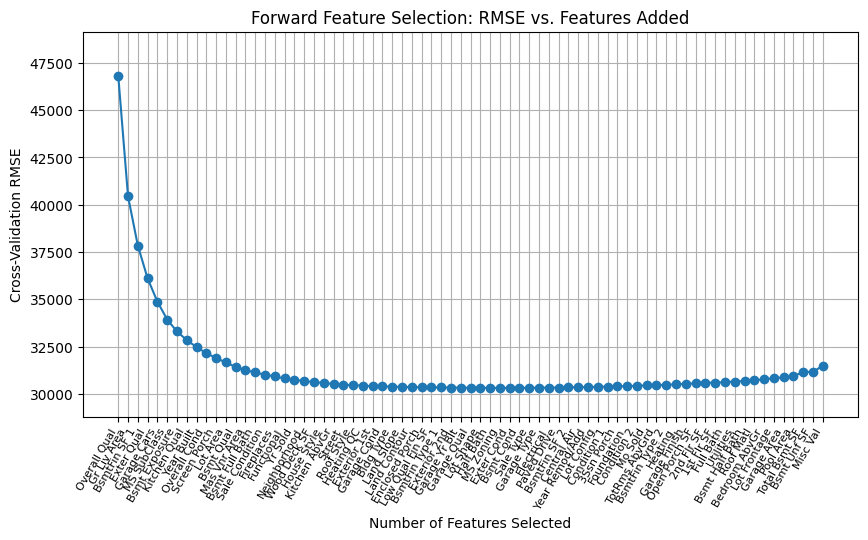

Best Feature Set: ['Overall Qual', 'Gr Liv Area', 'BsmtFin SF 1', 'Exter Qual', 'Garage Cars', 'MS SubClass', 'Bsmt Exposure', 'Kitchen Qual', 'Year Built', 'Overall Cond', 'Screen Porch', 'Lot Area', 'Bsmt Qual', 'Mas Vnr Area', 'Bsmt Full Bath', 'Sale Condition', 'Fireplaces', 'Functional', 'Yr Sold', 'Neighborhood', 'Wood Deck SF', 'House Style', 'Kitchen AbvGr', 'Street', 'Roof Style', 'Heating QC', 'Exterior 1st', 'Garage Cond', 'Bldg Type', 'Land Slope', 'Land Contour', 'Enclosed Porch', 'Low Qual Fin SF', 'BsmtFin Type 1', 'Exterior 2nd', 'Garage Yr Blt', 'Garage Qual', 'Lot Shape', 'Half Bath', 'MS Zoning', 'Exter Cond']
Best CV RMSE Score: 30312.7016


In [105]:
model = LinearRegression()

selected_features_forward, best_scores_forward, best_feature_set_forward, best_score_forward = forward_feature_selection(
    X_train, y_train, model, scoring='neg_mean_squared_error', cv=5
)

# MSE to RMSE
rmse_scores_forward = np.sqrt(best_scores_forward)
best_rmse_forward = np.sqrt(best_score_forward)

# Plot RMSE vs. Number of Features Selected
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(rmse_scores_forward) + 1), rmse_scores_forward, marker='o', linestyle='-')
plt.xlabel("Number of Features Selected")
plt.ylabel("Cross-Validation RMSE")
plt.title("Forward Feature Selection: RMSE vs. Features Added")
plt.xticks(range(1, len(selected_features_forward) + 1), selected_features_forward, rotation=60, ha='right', fontsize=8)
plt.grid(True)
plt.ylim(min(rmse_scores_forward) * 0.95, max(rmse_scores_forward) * 1.05)  # Adjust y-axis for better visibility
plt.show()

# Print results
print(f"Best Feature Set: {best_feature_set_forward}")
print(f"Best CV RMSE Score: {best_rmse_forward:.4f}")


### Problem One Graded Answers

In [106]:
# TODO:  Set the variable to the number of features in the best feature set found

a1a = len(best_feature_set_forward)

print(f'a1a = {a1a}')

a1a = 41


In [107]:
# TODO:  Set the variable to the best CV RMSE score found

a1b = best_rmse_forward                    # Just to get this cell to run without errors, insert your answer here

print(f"a1b = ${a1b:,.2f}")

a1b = $30,312.70


## **Problem Two: Backward Selection with the Ames Dataset**

Now, repeat the same process as in Problem One, but using the `backward_feature_selection` algorithm from this week’s video notebook.

**Steps to Follow:**
1. **Observe** that we have provided the `backward_feature_selection` algorithm from this week's video notebook for you to use.
2. **Run** the backward selection algorithm on the Ames dataset (`X_train` and `y_train`).
3. **Plot** the results: Display the Root Mean Squared Error (RMSE) vs. the features removed by the algorithm.
4. **Print** the Best Feature Set found by backward selection and the corresponding best CV RMSE Score.


In [108]:
# Backward Feature Selection

def backward_feature_selection(X, y, model, 
                               scoring='neg_mean_squared_error', 
                               cv=5, 
                               tol=None,               # None = no delta cutoff
                                                       # use 0.0 for "no further improvements"
                                                       # and 1e-4 for "point of diminishing returns"                                      
                               max_features=None,      # If None, remove features until only 1 remains
                                                       # Otherwise, stop when this many features remain
                               n_jobs=-1,
                               verbose=False
                              ):
    
    # Helper function to compute CV score using LinearRegression
    def cv_score(features):
        return -cross_val_score(model, X[features], y, 
                                scoring=scoring, cv=cv, 
                                n_jobs=n_jobs          ).mean()
    
    # Start with all features (using a list for easier manipulation)
    features_remaining = list(X.columns)
    
    # Compute initial CV score with the full feature set
    initial_score = cv_score(features_remaining)
    
    # Initialize tracking variables
    best_score        = initial_score                # Best (lowest) CV score observed so far
    best_feature_set  = features_remaining.copy()    # Feature set corresponding to best_score
    selected_features = ['NONE']                     # List to record the order in which features are removed
    best_scores       = [initial_score]              # List to record the CV score after each removal (starting with full set)
    
    if verbose:
        print("Start with full set of features:")
        print(f'{features_remaining}  CV score (MSE): {np.around(initial_score, 4)}\n')
    
    # Determine the target number of features to keep:
    # For backward elimination, if max_features is None, we remove until 1 feature remains.
    target_feature_count = 1 if max_features is None else max_features
    
    prev_score = initial_score
    round_num = 1
    # Continue removing features until we reach the target count
    while len(features_remaining) > target_feature_count:
        if verbose:
            print(f'Round {round_num}:')
            
        # Initialize variables to track the best removal in this round
        lowest_score = float('inf')
        feature_to_remove = None
        best_new_features = None
        
        # Try removing each feature one at a time
        for feature in features_remaining:
            new_feature_set = features_remaining.copy()
            new_feature_set.remove(feature)
            new_score = cv_score(new_feature_set)
            if verbose:
                print('Trying removal of:',feature, np.around(new_score, 4))
            if new_score < lowest_score:
                lowest_score = new_score
                feature_to_remove = feature
                best_new_features = new_feature_set
        
        # Check if improvement is significant enough (if tol is set)
        if tol is not None and (prev_score - lowest_score) < tol:
            if verbose:
                print("\nStopping early due to minimal improvement.")
            break
        
        # Update the best score and feature set if current removal improves performance
        if lowest_score < best_score:
            best_score = lowest_score
            best_feature_set = best_new_features.copy()
        
        # Update trackers for this round
        prev_score = lowest_score
        features_remaining = best_new_features
        selected_features.append(feature_to_remove)
        best_scores.append(lowest_score)
        
        if verbose:
            print(f'\nRemoving {feature_to_remove}:  CV score (MSE) {np.around(lowest_score, 4)}\n')
        round_num += 1

    return (
        selected_features,      # Order in which features were removed
        best_scores,            # CV scores after each removal step
        best_feature_set,       # Feature set that achieved the best CV score
        best_score              # Best (lowest) CV score
    )


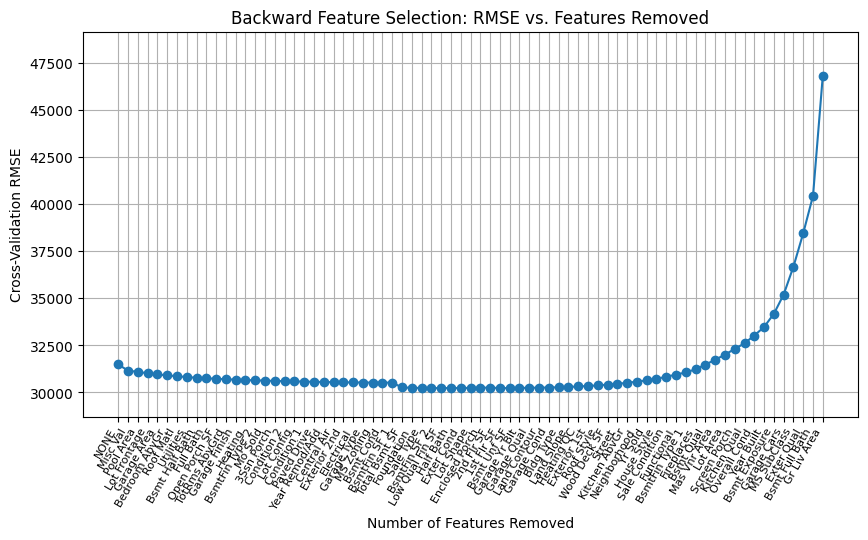

Best Feature Set: ['MS SubClass', 'Lot Area', 'Street', 'Land Contour', 'Land Slope', 'Neighborhood', 'Bldg Type', 'House Style', 'Overall Qual', 'Overall Cond', 'Year Built', 'Roof Style', 'Exterior 1st', 'Mas Vnr Area', 'Exter Qual', 'Bsmt Qual', 'Bsmt Exposure', 'BsmtFin Type 1', 'Bsmt Unf SF', 'Heating QC', 'Gr Liv Area', 'Bsmt Full Bath', 'Kitchen AbvGr', 'Kitchen Qual', 'Functional', 'Fireplaces', 'Garage Yr Blt', 'Garage Cars', 'Garage Qual', 'Garage Cond', 'Wood Deck SF', 'Screen Porch', 'Yr Sold', 'Sale Condition']
Best CV RMSE Score: 30232.4729


In [109]:
#Feature selection
selected_features_backward, best_scores_backward, best_feature_set_backward, best_score_backward = backward_feature_selection(
    X_train, y_train, model, scoring='neg_mean_squared_error', cv=5
)

# MSE to RMSE (dollars)
rmse_scores_backward = np.sqrt(best_scores_backward)
best_rmse_backward = np.sqrt(best_score_backward)

plt.figure(figsize=(10, 5))
plt.plot(range(1, len(rmse_scores_backward) + 1), rmse_scores_backward, marker='o', linestyle='-')
plt.xlabel("Number of Features Removed")
plt.ylabel("Cross-Validation RMSE")
plt.title("Backward Feature Selection: RMSE vs. Features Removed")
plt.xticks(range(1, len(selected_features_backward) + 1), selected_features_backward, rotation=60, ha='right', fontsize=8)
plt.grid(True)
plt.ylim(min(rmse_scores_backward) * 0.95, max(rmse_scores_backward) * 1.05)  # Adjust y-axis for better visibility as rec
plt.show()

print(f"Best Feature Set: {best_feature_set_backward}")
print(f"Best CV RMSE Score: {best_rmse_backward:.4f}")


### Problem Two Graded Answers

In [110]:
# TODO:  Set the variable to the number of features in the best feature set found

a2a = len(best_feature_set_backward)

print(f'a2a = {a2a}')

a2a = 34


In [111]:
# TODO:  Set the variable to the best CV RMSE score found

a2b = best_rmse_backward                   # Just to get this cell to run without errors, insert your answer here

print(f"a2b = ${a2b:,.2f}")

a2b = $30,232.47


## **Problem Three: Ridge Regression on the Ames Housing Dataset**

In this problem, we will apply Ridge Regression to the Ames Housing dataset. Ridge Regression includes a hyperparameter $\alpha$ that controls the strength of the regularization penalty, which helps prevent overfitting by constraining the growth of the model’s coefficients. A higher $\alpha$ penalizes large coefficients more, while a lower $\alpha$ allows them to grow larger.

When creating the model, the parameter must be specified, for example:

```python
ridge_model = Ridge(alpha=100)
```

This introduces another instance of the model selection problem: we must determine the value of $\alpha$ that yields the best CV RMSE score.

**Steps to Follow:**

1. **Standardize the Data:**  
   Ridge regression is sensitive to the scale of the features, so we will use `StandardScaler` to standardize the feature set to have a mean of 0 and a standard deviation of 1 before training and testing. Note that the target variable does **not** need to be scaled.

2. **Perform Cross-Validation Over a Range of Alpha Values:**  
   For each $\alpha \in \{100, 110, 120, \dots, 500\}$, calculate the cross-validation RMSE score for the model using 5-fold cross-validation.

3. **Visualize the Results:**  
   Plot the CV RMSE scores against the $\alpha$ values.

4. **Identify the Best Alpha:**  
   Determine the $\alpha$ that results in the minimum CV RMSE Score and print it out, along with the score.

**Tip:** It would be an *excellent* idea to add the suffix `_scaled` to any set to which you apply scaling.

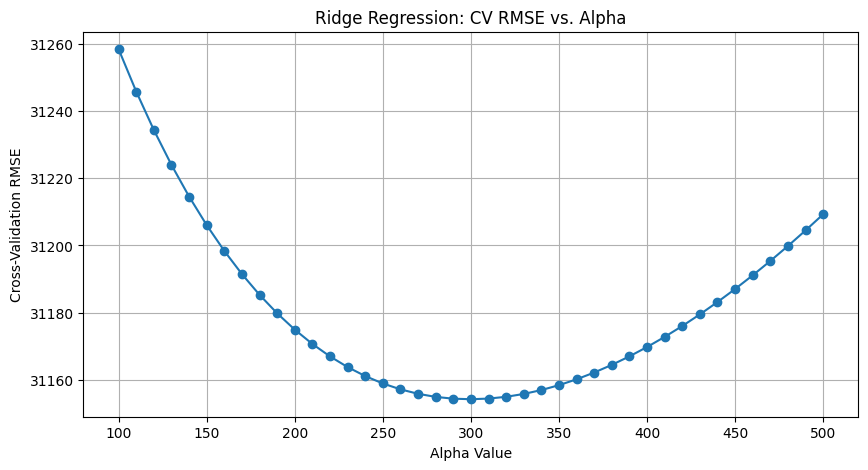

Best Alpha: 300
Best CV RMSE Score: 31154.3228


In [112]:
#standardizing the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)  # Not needed for CV, but useful for final model

#testing these alpha values
alpha_values = np.arange(100, 510, 10)

# results will be stores here
cv_rmse_scores = []

# Cross val for each alpha
for alpha in alpha_values:
    ridge_model = Ridge(alpha=alpha)
    mse_scores = cross_val_score(ridge_model, X_train_scaled, y_train, 
                                 scoring='neg_mean_squared_error', cv=5)
    rmse_score = np.sqrt(-mse_scores.mean())  # here we convert RMSE from MSE $$$$
    cv_rmse_scores.append(rmse_score)

#Best alpha?
best_alpha = alpha_values[np.argmin(cv_rmse_scores)]
best_rmse = min(cv_rmse_scores)

plt.figure(figsize=(10, 5))
plt.plot(alpha_values, cv_rmse_scores, marker='o', linestyle='-')
plt.xlabel("Alpha Value")
plt.ylabel("Cross-Validation RMSE")
plt.title("Ridge Regression: CV RMSE vs. Alpha")
plt.grid(True)
plt.show()

print(f"Best Alpha: {best_alpha}")
print(f"Best CV RMSE Score: {best_rmse:.4f}")


### Problem Three Graded Answers

In [113]:
# TODO:  Set the variable to the alpha determined to have the minimum CV RMSE score

a3a = best_alpha

print(f'a3a = {a3a}')

a3a = 300


In [114]:
# TODO:  Set the variable to the minimum CV RMSE score found

a3b = best_rmse                    # Just to get this cell to run without errors, insert your answer here

print(f"a3b = ${a3b:,.2f}")

a3b = $31,154.32


## **Problem Four: Evaluate Your Best Model**

In this final problem, you will identify the model with the best cross-validation RMSE score and evaluate its performance on the held-out test set.

#### **Steps to Follow:**

1. **Identify the Best Model:**
   From your previous results, select the model that achieved the lowest CV RMSE score.

3. **Train and Test the Selected Model:** 
   - For Forward or Backward Feature Selection:  Train a Linear Regression model using `X_train` **restricted to the selected best feature set**, and evaluate it on `X_test` restricted to the same feature set.
   - For Ridge Regression:   Train a Ridge Regression model using the best alpha found from cross-validation, with `StandardScaler` applied to both `X_train` and `X_test` before training and testing.

4. **Report Your Results:**
   Print the name of the best model and the test RMSE in dollars.



In [115]:
lowest_rmse = min(best_rmse_backward, best_rmse, best_rmse_forward)

print("Forward Feature Selection", best_rmse_forward)
print("Backward Feature Selection", best_rmse_backward)
print("Ridge Regression", best_rmse)

print("The lowest CV RMSE score:", lowest_rmse)

Forward Feature Selection 30312.70162026389
Backward Feature Selection 30232.47285803481
Ridge Regression 31154.32280720053
The lowest CV RMSE score: 30232.47285803481


In [116]:
X_train_selected = X_train[best_feature_set_backward] 
X_test_selected = X_test[best_feature_set_backward]

# Train
model.fit(X_train_selected, y_train)

# Predictions
y_pred = model.predict(X_test_selected)

# RMSE
test_rmse = np.sqrt(mean_squared_error(y_test, y_pred))


print("Best Model: Backward Feature Selection")
print(f"Test RMSE: ${test_rmse:.2f}")



Best Model: Backward Feature Selection
Test RMSE: $33731.86


### Problem Four Graded Answers

In [117]:
# TODO:  Set the variable to the best model, according to the CV RMSE score

a4a = 2                    # should be one of:  1 = Forward selection, 2 = Backward selection, or 3 = Ridge

print(f'a4a = {a4a}')

a4a = 2


In [118]:
# TODO:  Set the variable to the test RMSE for the best model

a4b = test_rmse                    # Just to get this cell to run without errors, insert your answer here

print(f"a4b = ${a4b:,.2f}")

a4b = $33,731.86


### Final question...

Why didn't we evaluate *all* the models on the test set and compare them?

We want to keep our test set completely seperate from our training data to avoid overfitting

### Optional

A better way to evaluate models, as we saw in the last homework, is to use repeated CV scoring to select the best model. We didn't do it in this homework because it results in long run times unless you have good computing resources. It would be an *excellent exercise* to redo the code above and see how repeated CV scoring affects the outcomes. For purposes of grading, however, just do the homework as stated. 